In [1]:
# Calculate the densimetric Froude number for layer i
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import os
import gsw

In [2]:
xdis = np.linspace(0.1, 9.9, 50) # Distance (km) in x direction

gh = np.repeat(np.array([[.5],[1],[1.5],[4],[8]]),10) # Grid height

In [5]:
def State_Interface(Hs):
    file = xr.open_dataset('/Users/weiyangbao/Documents/Model_outputs/State700/Hs_' + str(format(Hs,'03d')) + '.nc')
    state = file.isel(Y=range(1,10), T=range(60,len(file.T)))
    depth = state.Z.data
    pres = gsw.p_from_z(depth, 0)
    pt = state.Temp.data.mean(axis=(0,2)) # Y-axis average
    s = state.S.data.mean(axis=(0,2))
    p = np.tile(pres,[50,1]).T
    rho = gsw.rho(s, pt, p)
    
    u0 = state.U.data # dims = T, Z, Y, Xp1
    u_x = (u0[:, :, :, 1:] + u0[:, :, :, :-1]) / 2 # Convert the value to grid center in x direction
    u = u_x.mean(axis=(0,2)) # dims = Z, X
    #u[u==0] = np.nan
       
    Fr1 = np.empty(len(xdis)-2)
    Fr2 = np.empty(len(xdis)-2)
    val = np.empty(len(xdis)-2)
    for i in range(1,len(xdis)-1):           
        p = np.where(u[:,i] < 0)[-1][0]
        h1 = gh[:p].sum()
        u1 = np.sum(u[:p,i] * gh[:p]) / h1
        rho1 = np.sum(rho[:p,i] * gh[:p]) / h1
        
        if sum(j < 0 for j in u[p:,i]) == len(gh)-p:
            n = len(gh) - p
        else:    
            n = np.where(u[p:,i] >= 0)[-1][0]
            
        h2 = gh[p:p+n].sum()
        u2 = np.sum(u[p:p+n,i] * gh[p:p+n]) / h2
        rho2 = np.sum(rho[p:p+n,i] * gh[p:p+n]) / h2
            
        g = 9.8 * (rho2-rho1) / rho2
        Fr1[i-1] = u1 ** 2 / (g * h1)
        Fr2[i-1] = u2 ** 2 / (g * h2)
        val[i-1] = g
    return (Fr1, Fr2)

Hs = np.array([10, 12, 15, 110])

val1, F11, F21 = State_Interface(Hs[0])
val2, F12, F22 = State_Interface(Hs[1])
val3, F13, F23 = State_Interface(Hs[2])


val1[27], F11[27], F21[27]

val2[27], F12[27], F22[27]

val3[27], F13[27], F23[27]m

Text(0.0, 1.0, '(d) $\\mathregular{H_s}$ = 110 m')

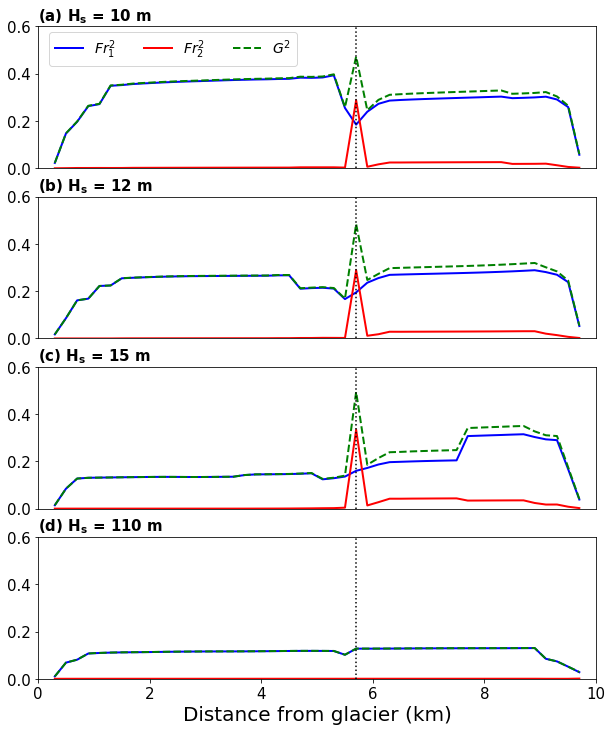

In [7]:
Hs = np.array([10, 12, 15, 110])

F11, F21 = State_Interface(Hs[0])
F12, F22 = State_Interface(Hs[1])
F13, F23 = State_Interface(Hs[2])
F14, F24 = State_Interface(Hs[3])


# Make plots
fig = plt.figure(figsize=(10,12))
#fig.tight_layout()
ax1 = fig.add_subplot(411)
ax1.plot(xdis[1:-1],F11,'b-',linewidth=2)
ax1.plot(xdis[1:-1],F21,'r-',linewidth=2)
ax1.plot(xdis[1:-1],F11+F21,'g--',linewidth=2)
ax1.axvline(x=xdis[28],color='k',linestyle=':')
plt.legend(['$Fr_1^2$','$Fr_2^2$','$G^2$'], loc='upper left', fontsize=14, bbox_to_anchor=(.02, .96) , borderaxespad=0., ncol=3)
ax1.set_xlim([0,10])
ax1.set_ylim([0,.6])
ax1.tick_params(axis='y', labelsize=15)
#plt.text(8.5, 1.8, r'$h_1/h_s= $' + str(format(h1s,'.3f')), {'fontsize': 15})
#plt.text(8.5, 1.6, r'$u_1/u_f= $' + str(format(u1f,'.2f')), {'fontsize': 15})
#plt.title("Sill depth: " + str(sill_depth) + ' m, Q$_{f}$: ' + str(Qsg) + ' m\u00B3/s', size = 20, weight = 'bold')
ax1.axes.get_xaxis().set_visible(False)
ax1.set_title('(a) $\mathregular{H_s}$ = ' + str(Hs[0]) + ' m', loc='left', size=15, weight='bold')


ax2 = fig.add_subplot(412)
ax2.plot(xdis[1:-1],F12,'b-',linewidth=2)
ax2.plot(xdis[1:-1],F22,'r-',linewidth=2)
ax2.plot(xdis[1:-1],F12+F22,'g--',linewidth=2)
ax2.axvline(x=xdis[28],color='k',linestyle=':')
ax2.tick_params(axis='y', labelsize=15)
ax2.set_xlim([0,10])
ax2.set_ylim([0,.6])
ax2.axes.get_xaxis().set_visible(False)
ax2.set_title('(b) $\mathregular{H_s}$ = ' + str(Hs[1]) + ' m', loc='left', size=15, weight='bold')


ax3 = fig.add_subplot(413)
ax3.plot(xdis[1:-1],F13,'b-',linewidth=2)
ax3.plot(xdis[1:-1],F23,'r-',linewidth=2)
ax3.plot(xdis[1:-1],F13+F23,'g--',linewidth=2)
ax3.axvline(x=xdis[28],color='k',linestyle=':')
ax3.set_xlim([0,10])
ax3.set_ylim([0,.6])
ax3.tick_params(axis='y', labelsize=15)
ax3.axes.get_xaxis().set_visible(False)
ax3.set_title('(c) $\mathregular{H_s}$ = ' + str(Hs[2]) + ' m', loc='left', size=15, weight='bold')


ax4 = fig.add_subplot(414)
ax4.plot(xdis[1:-1],F14,'b-',linewidth=2)
ax4.plot(xdis[1:-1],F24,'r-',linewidth=2)
ax4.plot(xdis[1:-1],F14+F24,'g--',linewidth=2)
ax4.axvline(x=xdis[28],color='k',linestyle=':')
ax4.set_xlim([0,10])
ax4.set_ylim([0,.6])
ax4.tick_params(axis='y', labelsize=15)
ax4.tick_params(axis='x', labelsize=15)
ax4.set_xlabel('Distance from glacier (km)', size=20)
ax4.set_title('(d) $\mathregular{H_s}$ = ' + str(Hs[3]) + ' m', loc='left', size=15, weight='bold')


In [8]:
fig_path = "/Users/weiyangbao/Documents/Model_outputs/Froude/"
if not os.path.exists(fig_path):
    os.makedirs(fig_path)
fig.savefig(fig_path + '/Fr_i.png', dpi = 150, bbox_inches='tight') 